In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
import os

print(cv2.__version__, cv2.__spec__)
#print(cv2.getBuildInformation())

import shutil
import itertools
import imutils
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

4.7.0 ModuleSpec(name='cv2', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f7f885c92d0>, origin='/usr/local/lib/python3.10/dist-packages/cv2/__init__.py', submodule_search_locations=['/usr/local/lib/python3.10/dist-packages/cv2'])


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

folder_path = "/content/drive/MyDrive/Colab_Notebooks/braintumor_dataset";

Mounted at /content/drive


In [4]:
yes_path = "/content/drive/MyDrive/Colab_Notebooks/braintumor_dataset/yes_tumor"
no_path ="/content/drive/MyDrive/Colab_Notebooks/braintumor_dataset/no_tumor"

In [5]:
# Initialize empty lists to store the images and labels
images = []
labels = []

# Extract the images and labels from the yes folder
for filename in os.listdir(yes_path):
    img = cv2.imread(os.path.join(yes_path, filename))
    if img is not None:
        images.append(img)
        labels.append(1)

# Extract the images and labels from the no folder
for filename in os.listdir(no_path):
    img = cv2.imread(os.path.join(no_path, filename))
    if img is not None:
        images.append(img)
        labels.append(0)

In [6]:
# Convert the images and labels to numpy arrays
images = np.array(images, dtype=object)
labels = np.array(labels, dtype=object)

print('Shape of images:', images.shape)
print('Shape of labels:', labels.shape)

Shape of images: (1180,)
Shape of labels: (1180,)


Resizing dataset images

In [7]:
from skimage import transform

# Assume that you have already loaded your images and labels into numpy arrays
# and named them "images" and "labels"

# Define the desired width and height for the resized images
width, height = 224, 224

# Create an empty array to store the resized images
resized_images = np.empty((images.shape[0], width, height,3), dtype=np.float32)

# Loop over each image and resize it
for i in range(images.shape[0]):
    resized_images[i] = transform.resize(images[i], (width, height))

# Verify the shape of the resized image array
print("Resized images shape:", resized_images.shape)


Resized images shape: (1180, 224, 224, 3)


Splitting data intro training, validation and testing set

In [8]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(resized_images, labels, test_size=0.2, random_state=42, stratify=labels)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
val_images = val_images.astype('float32')

from keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

# Verify the shape of the training and testing sets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Val images shape:", val_images.shape)
print("Val labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (755, 224, 224, 3)
Train labels shape: (755, 2)
Val images shape: (189, 224, 224, 3)
Val labels shape: (189, 2)
Test images shape: (236, 224, 224, 3)
Test labels shape: (236, 2)


Images shape: (30, 1, 224, 224, 3)


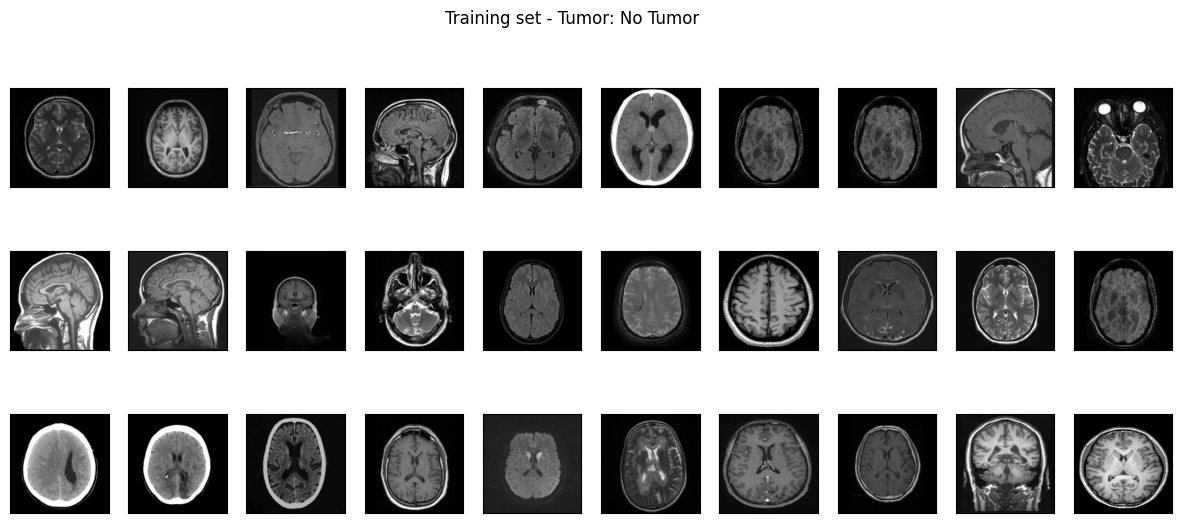

Images shape: (30, 1, 224, 224, 3)


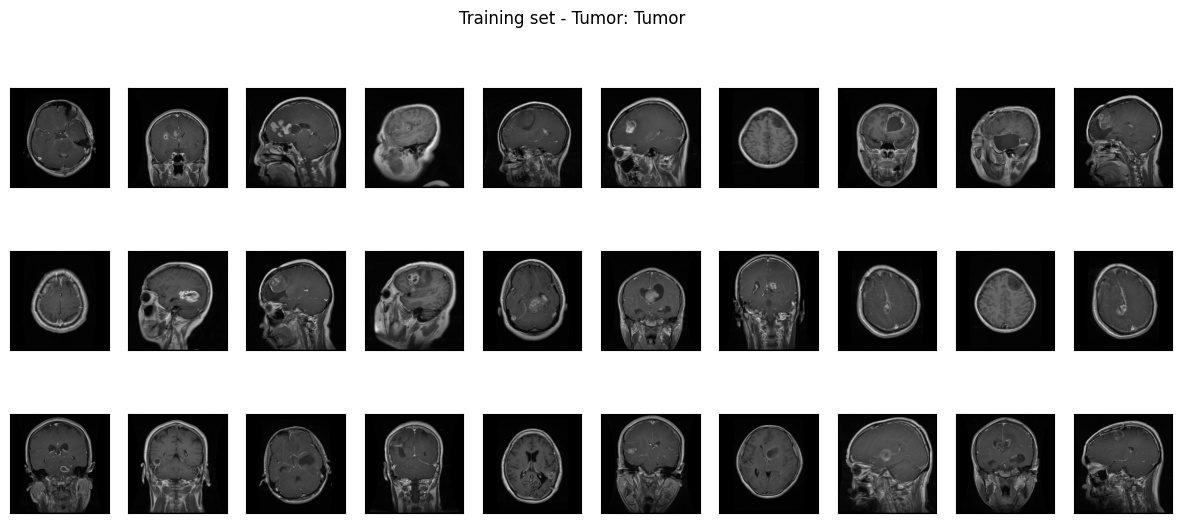

In [9]:
def plot_samples(X, y, labels_dict, n=50, set_name='Training'):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        labels = np.argmax(y, axis=1)
        imgs = X[np.argwhere(labels == index)][:n]
        print('Images shape:', imgs.shape)
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('{} set - Tumor: {}'.format(set_name, labels_dict[index]))
        plt.show()

plot_samples(train_images, train_labels, {0: 'No Tumor', 1: 'Tumor'}, n=30, set_name='Training')

Training Data Set using MobileNet CNN


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.layers import Dense, Flatten

mobNet = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)

flatten = Flatten()(mobNet.output)
dense1 = Dense(128, activation='relu')(flatten)
output = Dense(2, activation='sigmoid')(dense1)

model = Model(inputs=mobNet.input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(val_images, val_labels))

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/20
24/24 [==============================] - 31s 204ms/step - loss: 2.1347 - accuracy: 0.8636 - val_loss: 1.8576 - val_accuracy: 0.7937
Epoch 2/20
24/24 [==============================] - 3s 120ms/step - loss: 0.1892 - accuracy: 0.9775 - val_loss: 6.3835 - val_accuracy: 0.6720
Epoch 3/20
24/24 [==============================] - 3s 123ms/step - loss: 0.0588 - accuracy: 0.9921 - val_loss: 5.4727 - val_accuracy: 0.7090
Epoch 4/20
24/24 [==============================] - 3s 125ms/step - loss: 0.0405 - accuracy: 0.9907 - val_loss: 6.8160 - val_accuracy: 0.6085
Epoch 5/20
24/24 [==============================] - 3s 119ms/step - loss: 0.0041 - accuracy: 0.9960 - val_loss: 3.7567 - val_accuracy: 0.7460
Epoch 6/20
24/24 [==============================] - 3s 116ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.6378 - val_accuracy: 0.9206
Epoch 7/20
24/24 [==============================] - 3s 120ms/step - loss: 0.0356 -

MobileNet Confusion Matrix

8/8 [==============================] - 2s 135ms/step
Normalized confusion matrix
[[1.         0.        ]
 [0.02941176 0.97058824]]


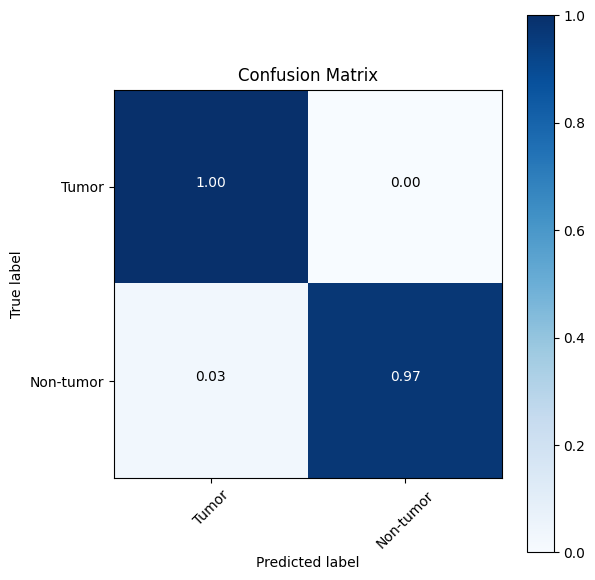

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.97      0.99       136

    accuracy                           0.98       236
   macro avg       0.98      0.99      0.98       236
weighted avg       0.98      0.98      0.98       236



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


#function to build confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the labels for the testing set
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
class_names = ['Tumor', 'Non-tumor']
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion Matrix')
plt.show()

# Performance metrics 
print(classification_report(y_true, y_pred))

MobileNet Model Accuracy & Model Loss

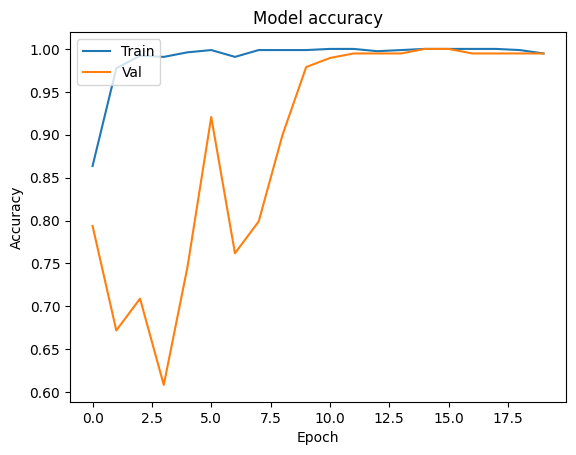

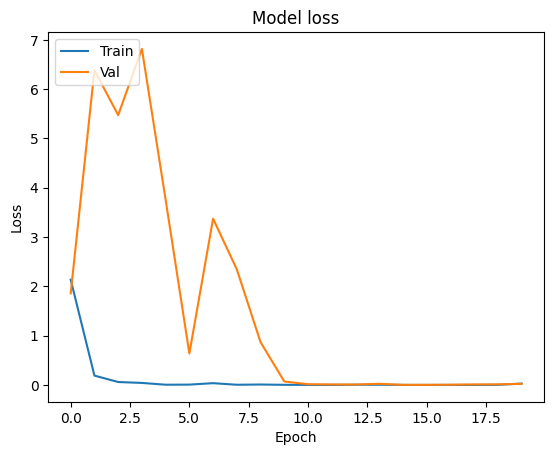

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()